### Installing Packages and Dependencies

```
conda create -n interpretabnet python=3.10
conda activate interpretabnet
```

```
pip install -r requirements.txt
```

### Importing Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import wget
import math

from pathlib import Path
from matplotlib import pyplot as plt
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.model_selection import train_test_split
np.random.seed(0)

### Data Processing

Create a directory named "data" within InterpreTabNet.

```
mkdir data
```

Download and place your desired dataset into /InterpreTabNet/data.

Modify the below according to the comments to process your dataset. The following is an example for the "Adult" dataset.

In [37]:
dataset = 'census-income' # Modify Dataset Name

out = Path(os.getcwd() + '/data/' + dataset + '.csv')
train = pd.read_csv(out)

target = ' <=50K' # Modify Target Name

if "Set" not in train.columns:
    train["Set"] = np.random.choice(["train", "valid", "test"], p=[.8, .1, .1], size=(train.shape[0],))

train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

nunique = train.nunique()
types = train.dtypes

categorical_columns = []
categorical_dims = {}
for col in train.columns:
    if types[col] == 'object' or nunique[col] < 200:
        # print(col, train[col].nunique())
        l_enc = LabelEncoder()
        train[col] = train[col].fillna("VV_likely")
        train[col] = l_enc.fit_transform(train[col].values)
        categorical_columns.append(col)
        categorical_dims[col] = len(l_enc.classes_)
    else:
        train.fillna(train.loc[train_indices, col].mean(), inplace=True)

# Setting the target as a categorical feature
train.loc[train[target] == 0, target] = "wealthy"
train.loc[train[target] == 1, target] = "not_wealthy"

unused_feat = ['Set']

features = [col for col in train.columns if col not in unused_feat + [target]]

cat_idxs = [i for i, f in enumerate(features) if f in categorical_columns]

cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]

X_train = train[features].values[train_indices]
y_train = train[target].values[train_indices]

X_valid = train[features].values[valid_indices]
y_valid = train[target].values[valid_indices]

X_test = train[features].values[test_indices]
y_test = train[target].values[test_indices]

File already exists.


/tmp/ipykernel_973557/3176484843.py:38: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'wealthy' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  train.loc[train[target] == 0, target] = "wealthy"


### Tuning Hyperparameters

In [13]:
nd_na = [16, 32, 128]
n_steps = [3, 4]
gammas = [1.0, 1.2, 1.5, 2.0]
learn_r = [0.005, 0.01, 0.02, 0.025]

opt_ndna = 32
opt_nsteps = 3
opt_gamma = 1.5
opt_lr = 0.025

ndna_test_acc = 0
for ndna in nd_na:
    clf = TabNetClassifier(
        n_d=ndna,
        n_a=ndna,
        n_steps=n_steps[0],
        gamma=gammas[0],
        lambda_sparse=1.0,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        optimizer_params=dict(lr=learn_r[0]),
        mask_type = 'softmax'
    )

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'], batch_size=256,
        virtual_batch_size=256,
        max_epochs=10, eval_metric=['accuracy']
    )

    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

    if test_acc > ndna_test_acc:
        opt_ndna = ndna
        ndna_test_acc = test_acc
        print("Optimum Hyperparameters Training", [opt_ndna, opt_nsteps, opt_gamma, opt_lr])

nstep_test_acc = 0
for nstep in n_steps:

    clf = TabNetClassifier(
        n_d=opt_ndna,
        n_a=opt_ndna,
        n_steps=nstep,
        gamma=gammas[0],
        lambda_sparse=1.0,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        optimizer_params=dict(lr=learn_r[0]),
        mask_type = 'softmax'
    )

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'], batch_size=256,
        virtual_batch_size=256,
        max_epochs=10, eval_metric=['accuracy']
    )

    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

    if test_acc > nstep_test_acc:
        opt_nsteps = nstep
        nstep_test_acc = test_acc
        print("Optimum Hyperparameters Training", [opt_ndna, opt_nsteps, opt_gamma, opt_lr])

gams_test_acc = 0
for gams in gammas:
    clf = TabNetClassifier(
        n_d=opt_ndna,
        n_a=opt_ndna,
        n_steps=opt_nsteps,
        gamma=gams,
        lambda_sparse=1.0,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        optimizer_params=dict(lr=learn_r[0]),
        mask_type = 'softmax'
    )

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'], batch_size=256,
        virtual_batch_size=256,
        max_epochs=10, eval_metric=['accuracy']
    )

    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    if test_acc > gams_test_acc:
        opt_gamma = gams
        gams_test_acc = test_acc
        print("Optimum Hyperparameters Training", [opt_ndna, opt_nsteps, opt_gamma, opt_lr])

lr_test_accuracy = 0
for lr in learn_r:
    clf = TabNetClassifier(
        n_d=opt_ndna,
        n_a=opt_ndna,
        n_steps=opt_nsteps,
        gamma=opt_gamma,
        lambda_sparse=1.0,
        cat_idxs=cat_idxs,
        cat_dims=cat_dims,
        optimizer_params=dict(lr=lr),
        mask_type = 'softmax'
    )

    clf.fit(
        X_train=X_train, y_train=y_train,
        eval_set=[(X_train, y_train), (X_valid, y_valid)],
        eval_name=['train', 'valid'], batch_size=256,
        virtual_batch_size=256,
        max_epochs=10, eval_metric=['accuracy']
    )

    y_pred = clf.predict(X_test)
    test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)
    if test_acc > lr_test_accuracy:
        opt_lr = lr
        lr_test_accuracy = test_acc
        print("Optimum Hyperparameters Training", [opt_ndna, opt_nsteps, opt_gamma, opt_lr])

print("Optimum Hyperparameters", [opt_ndna, opt_nsteps, opt_gamma, opt_lr])

Device used cuda: 0


epoch 0  | loss: 0.37305 | train_accuracy: 0.9229  | valid_accuracy: 0.92986 |  0:00:04s
epoch 1  | loss: 0.08623 | train_accuracy: 0.9162  | valid_accuracy: 0.9234  |  0:00:07s
epoch 2  | loss: 0.03123 | train_accuracy: 0.9199  | valid_accuracy: 0.93124 |  0:00:11s
epoch 3  | loss: 0.01039 | train_accuracy: 0.91736 | valid_accuracy: 0.9317  |  0:00:15s
epoch 4  | loss: 0.00388 | train_accuracy: 0.91898 | valid_accuracy: 0.93309 |  0:00:19s
epoch 5  | loss: 0.0008  | train_accuracy: 0.92982 | valid_accuracy: 0.94186 |  0:00:23s
epoch 6  | loss: -0.00032| train_accuracy: 0.93813 | valid_accuracy: 0.95155 |  0:00:26s
epoch 7  | loss: -0.00089| train_accuracy: 0.94922 | valid_accuracy: 0.95754 |  0:00:30s
epoch 8  | loss: -0.00062| train_accuracy: 0.97045 | valid_accuracy: 0.97508 |  0:00:34s
epoch 9  | loss: -0.00133| train_accuracy: 0.98453 | valid_accuracy: 0.98662 |  0:00:38s
Stop training because you reached max_epochs = 10 with best_epoch = 9 and best_valid_accuracy = 0.98662
Best w

In [34]:
opt_ndna = 32
opt_nsteps = 4
opt_gamma = 1.0
opt_lr = 0.025

### Tuning Sparsity Regularizer $r_M$

Note: For an even quicker process, you could directly modify the "opt_reg_m" in the "Optimized Run" block below and optimize in the range of 0 - 1000000000 w.r.t the accuracy/sparsity (interpretability) tradeoff from the feature mask visualization.

In [48]:
def search_best_reg_m(start=0, end=100000000, col_threshold_val=0.20, col_threshold=3, all_mask_pass=None, all_mask_pass_thresh=3, step_size=None, best_reg_m=None, reg_m_acc_dict=None, is_recursive=False):
        if reg_m_acc_dict is None:
                reg_m_acc_dict = {}

        if all_mask_pass == all_mask_pass_thresh:
                print(reg_m_acc_dict)
                final_reg_m = max(reg_m_acc_dict, key=reg_m_acc_dict.get)
                return final_reg_m
            
        if all_mask_pass is None:
                all_mask_pass = 0
            
        # Fine-tuning around the best found value
        best_reg_m = None
        break_outer_loop = False

        # Determining Magnitude for reg_m
        diff = end - start
        magnitude = int(math.log10(diff))

        reg_m = start
        while reg_m <= end and all_mask_pass < all_mask_pass_thresh: #do i need all_mask_pass threshold here?
                print("reg_m", reg_m)
                if reg_m in reg_m_acc_dict:
                    reg_m += step_size
                    continue
                clf = TabNetClassifier(
                    n_d=opt_ndna,
                    n_a=opt_ndna,
                    n_steps=4,
                    gamma=opt_gamma,
                    lambda_sparse=1.0,
                    cat_idxs=cat_idxs,
                    cat_dims=cat_dims,
                    optimizer_params=dict(lr=opt_lr),
                    mask_type = 'softmax',
                    reg_m=reg_m
                )
                # max epoch 50
                clf.fit(
                    X_train=X_train, y_train=y_train,
                    eval_set=[(X_train, y_train), (X_valid, y_valid)],
                    eval_name=['train', 'valid'],
                    max_epochs=30, eval_metric=['accuracy']
                )

                y_pred = clf.predict(X_test)
                test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

                print(f"FINAL TEST SCORE FOR {dataset} : {test_acc}")

                explain_matrix, masks = clf.explain(X_test)

                # Extract the first 50 samples from each matrix
                masks_dict = {}
                for key, value in masks.items():
                    masks_dict[key] = value[:50]

                # Normalize each extracted matrix so that its sum is 1
                for key, value in masks_dict.items():
                    total_sum = value.sum()
                    
                    # Avoid division by zero
                    if total_sum == 0:
                        continue
                    
                    masks_dict[key] = value / total_sum

                mask_threshold = opt_nsteps // 2 + 1
                mask_pass_count = 0

                for key, value in masks_dict.items():
                    column_sums = value.sum(axis=0)
                    # print(f"Sum of columns for matrix with key {key}: {column_sums}")

                    # Check which columns are greater than col_threshold_val
                    cols_above_threshold = [i for i, col_sum in enumerate(column_sums) if col_sum > col_threshold_val]
                    print(f"Columns in matrix with key {key} that are greater than the threshold value: {cols_above_threshold}")

                    if col_threshold-1 <= len(cols_above_threshold) <= col_threshold+1:
                        mask_pass_count += 1
                        print("Num Mask Pass Threshold:", mask_pass_count)
                    if mask_pass_count >= mask_threshold:
                        if len(reg_m_acc_dict) == 0:
                            all_mask_pass += 1
                            best_reg_m = reg_m
                            reg_m_acc_dict[reg_m] = test_acc
                            break_outer_loop = True
                            break
                        elif test_acc > max(reg_m_acc_dict.values()):
                            all_mask_pass += 1
                            reg_m_acc_dict[reg_m] = test_acc
                            best_reg_m = reg_m
                            break
                        else:
                            print("Lesser Acc, Break")
                            break
                    
                if break_outer_loop:
                    break

                if is_recursive:
                    reg_m += step_size
                elif reg_m == 0:
                    reg_m = 10
                else:
                    reg_m *= 10


        # Check conditions after looping over all possible reg_m values
        if best_reg_m is not None and len(reg_m_acc_dict) == 1: # i need to add the condition where i hit all mask pass and return the funct directly
                print('Breaked')
                magnitude = math.floor(math.log10(best_reg_m))
                if magnitude >= 1:
                    step_size = 10**(magnitude-1)
                else:
                    step_size = 10**(magnitude)
                # Recursively refine the search with updated boundaries and reduced depth
                new_start = int(max(start, best_reg_m - step_size))
                new_end = int(min(end, best_reg_m + step_size))
                return search_best_reg_m(new_start, new_end, col_threshold, col_threshold_val, all_mask_pass, all_mask_pass_thresh, step_size, best_reg_m, reg_m_acc_dict, is_recursive=True)
        elif len(reg_m_acc_dict)==0:
                return "Did not pass! Increase start/end Search Range!"
        else:
                final_reg_m = max(reg_m_acc_dict, key=reg_m_acc_dict.get)
                return final_reg_m

In [49]:
opt_reg_m = search_best_reg_m()
print("opt_reg_m for Best Mask", opt_reg_m)

reg_m 0
Device used cuda: 0


epoch 0  | loss: -1.08538| train_accuracy: 0.78576 | valid_accuracy: 0.77255 |  0:00:10s
epoch 1  | loss: -1.3059 | train_accuracy: 0.8347  | valid_accuracy: 0.82172 |  0:00:20s
epoch 2  | loss: -1.34094| train_accuracy: 0.84011 | valid_accuracy: 0.82866 |  0:00:30s
epoch 3  | loss: -1.35046| train_accuracy: 0.83732 | valid_accuracy: 0.82986 |  0:00:40s
epoch 4  | loss: -1.36552| train_accuracy: 0.8274  | valid_accuracy: 0.82262 |  0:00:50s
epoch 5  | loss: -1.37592| train_accuracy: 0.82539 | valid_accuracy: 0.82293 |  0:01:00s
epoch 6  | loss: -1.38363| train_accuracy: 0.81311 | valid_accuracy: 0.80784 |  0:01:10s
epoch 7  | loss: -1.3882 | train_accuracy: 0.81701 | valid_accuracy: 0.81388 |  0:01:20s
epoch 8  | loss: -1.39216| train_accuracy: 0.83223 | valid_accuracy: 0.82624 |  0:01:30s
epoch 9  | loss: -1.39386| train_accuracy: 0.85698 | valid_accuracy: 0.84796 |  0:01:40s
epoch 10 | loss: -1.39963| train_accuracy: 0.81709 | valid_accuracy: 0.81026 |  0:01:50s
epoch 11 | loss: -1.3

### Optimized Run

In [43]:
opt_reg_m = 9

In [52]:
print(opt_ndna, opt_nsteps, opt_gamma, opt_lr, opt_reg_m)

32 4 1.0 0.025 10


Device used cuda: 0


epoch 0  | loss: 41.52055| train_accuracy: 0.7863  | valid_accuracy: 0.76802 |  0:00:10s
epoch 1  | loss: 41.46963| train_accuracy: 0.83786 | valid_accuracy: 0.82443 |  0:00:20s
epoch 2  | loss: 41.38733| train_accuracy: 0.8474  | valid_accuracy: 0.8365  |  0:00:30s
epoch 3  | loss: 41.19034| train_accuracy: 0.84586 | valid_accuracy: 0.83409 |  0:00:40s
epoch 4  | loss: 41.28685| train_accuracy: 0.8296  | valid_accuracy: 0.82353 |  0:00:50s
epoch 5  | loss: 41.19909| train_accuracy: 0.83153 | valid_accuracy: 0.82504 |  0:01:00s
epoch 6  | loss: 41.02058| train_accuracy: 0.84532 | valid_accuracy: 0.83167 |  0:01:10s
epoch 7  | loss: 40.91159| train_accuracy: 0.74486 | valid_accuracy: 0.746   |  0:01:20s
epoch 8  | loss: 40.91569| train_accuracy: 0.73266 | valid_accuracy: 0.727   |  0:01:30s
epoch 9  | loss: 40.82945| train_accuracy: 0.83617 | valid_accuracy: 0.81991 |  0:01:40s
epoch 10 | loss: 40.88273| train_accuracy: 0.81149 | valid_accuracy: 0.80422 |  0:01:50s
epoch 11 | loss: 40.5

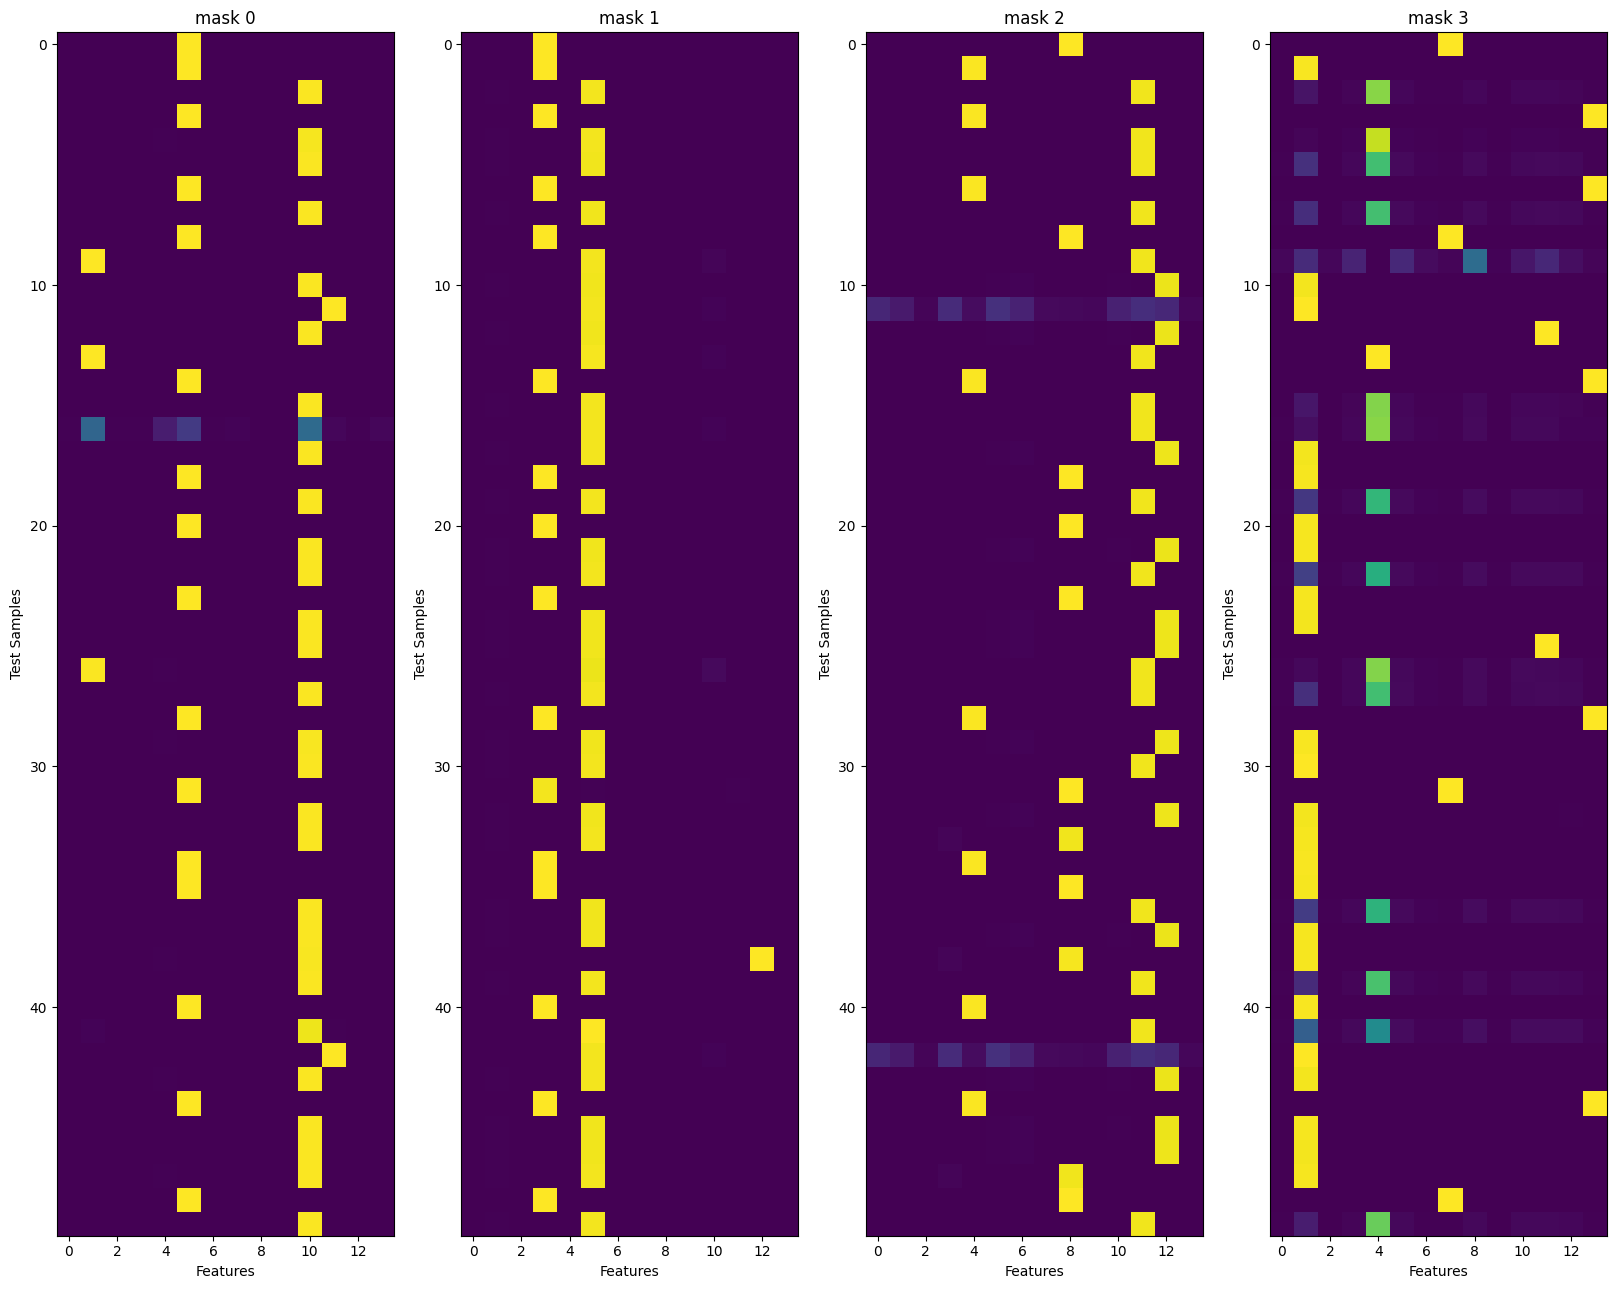

In [46]:
clf = TabNetClassifier(
    n_d=opt_ndna,
    n_a=opt_ndna,
    n_steps=opt_nsteps,
    gamma=opt_gamma,
    lambda_sparse=1.0,
    cat_idxs=cat_idxs,
    cat_dims=cat_dims,
    optimizer_params=dict(lr=opt_lr),
    mask_type = 'softmax',
    reg_m=opt_reg_m
)
clf.fit(
    X_train=X_train, y_train=y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    eval_name=['train', 'valid'],
    max_epochs=100, eval_metric=['accuracy']
)

y_pred = clf.predict(X_test)
test_acc = accuracy_score(y_pred=y_pred, y_true=y_test)

print(f"FINAL TEST SCORE FOR {dataset} : {test_acc}")

explain_matrix, masks = clf.explain(X_test)
fig, axs = plt.subplots(1, opt_nsteps, figsize=(20, 20))
for i in range(opt_nsteps):
    axs[i].imshow(masks[i][:50])
    axs[i].set_title(f"mask {i}")
    axs[i].set_ylabel("Test Samples")
    axs[i].set_xlabel("Features")
plt.savefig(f"{dataset}_feature_mask_kld_{opt_reg_m}_accuracy_{test_acc}.png")